# Upload dataset
https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

# print("Path to dataset files:", path)

#### Dataset moved to fake-data-detector/data

100%|██████████| 105M/105M [01:51<00:00, 980kB/s]  

Extracting files...


Path to dataset files: /home/romaric/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


https://www.tensorflow.org/tutorials/load_data/images

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

2025-02-18 20:32:01.441385: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-18 20:32:01.566359: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-18 20:32:01.642955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739881921.703885   45130 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739881921.717210   45130 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 20:32:01.900771: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [12]:
dataset_root = r"/home/romaric/code/nghia95/fake-data-detector/data/birdy654/train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_root,  # Path to the directory containing 'FAKE' and 'REAL'
    label_mode="binary",  # If there are only two classes (FAKE/REAL)
)

Found 100000 files belonging to 2 classes.


W0000 00:00:1739882483.701979   45130 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [17]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

Batch shape: (32, 256, 256, 3)
Labels shape: (32, 1)


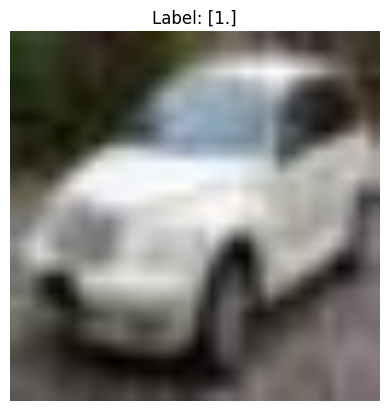

In [18]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
image_batch, label_batch = next(iter(train_ds))

# Show the shape of the data
print("Batch shape:", image_batch.shape)  # (batch_size, height, width, channels)
print("Labels shape:", label_batch.shape)  # (batch_size,)

# Display the first image in the batch
plt.imshow(image_batch[0].numpy().astype("uint8"))
plt.title(f"Label: {label_batch[0].numpy()}")
plt.axis("off")
plt.show()

In [19]:
print("Class names:", train_ds.class_names)

Class names: ['FAKE', 'REAL']


Image batch shape: (32, 256, 256, 3)
Label batch shape: (32, 1)


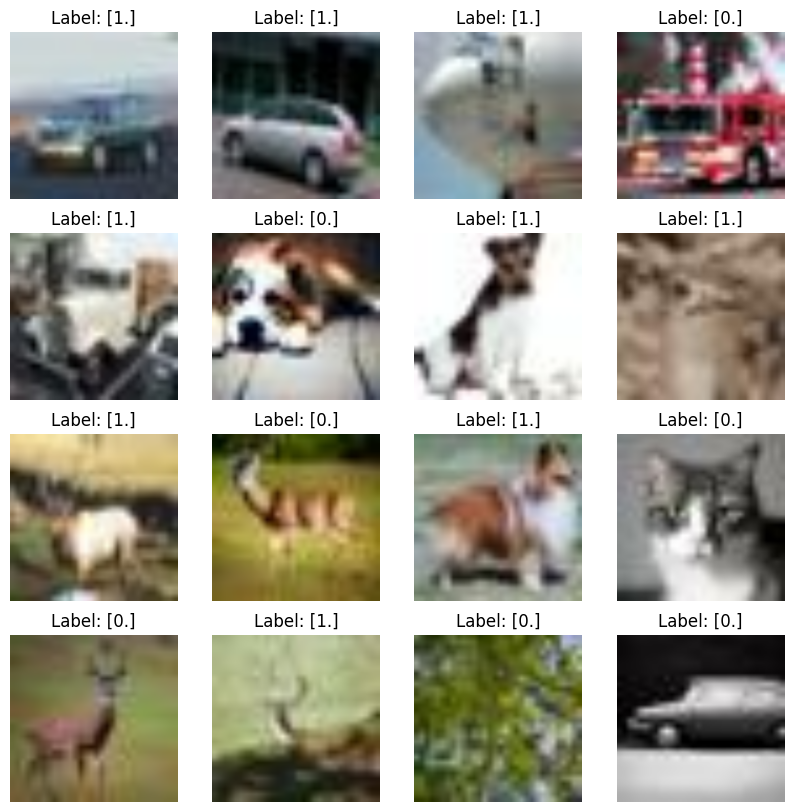

2025-02-18 20:49:03.367676: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
for images, labels in train_ds.take(1):  # Take only 1 batch
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

    # Show multiple images from the batch
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(f"Label: {labels[i].numpy()}")
        ax.axis("off")

    plt.show()